In [1]:
#import library
import os
import numpy as np
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, matthews_corrcoef, cohen_kappa_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 100k shuffled data
with open('/content/drive/Shareddrives/SignLanguageData/combined_augmented_data_v3.pkl','rb') as f:
  X_train,y_train,X_test,y_test = pickle.load(f)


In [4]:
#printing shapes 
print(f'X_train Shape: {X_train.shape}')
print(f'y_train Shape: {y_train.shape}')
print(f'X_test Shape: {X_test.shape}')
print(f'y_test Shape: {y_test.shape}')

X_train Shape: (109820, 28, 28)
y_train Shape: (109820,)
X_test Shape: (28688, 28, 28)
y_test Shape: (28688,)


In [5]:
#define image resolution 
res = (28,28)

#fuction to find the indices given a label 
def find_indices(data,label):
    #check if data is numpy array
    if type(data) == np.ndarray:
        #return indices
        return np.where(data==label)
    #check if data is pandas series 
    elif type(data) == pd.Series:
        #return indices
        return data[data==label].index
    #else not supported in this function
    else:
        raise Exception('Not supported data type for this function.')

In [6]:
#letters
letters = ['A','B','C','D','E','F','G','H','I','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y']
#numbers 
numbers = sorted(list(np.unique(y_train.astype(int))))
#dictionary of labels 
labels = dict(zip(numbers,letters))

In [ ]:
# # Reshape the data to (num_samples, 784)
# X_train = X_train.reshape(X_train.shape[0], -1)
# X_test = X_test.reshape(X_test.shape[0], -1)
# y_train = y_train
# y_test = y_test
# # Print the shapes of the augmented data
# print(f'X_train shape: {X_train.shape}')
# print(f'y_train shape: {y_train.shape}')
# print(f'X_test shape: {X_test.shape}')
# print(f'y_test shape: {y_test.shape}')

In [7]:
# Normalizing the data
X_train = X_train/255
X_test = X_test/255

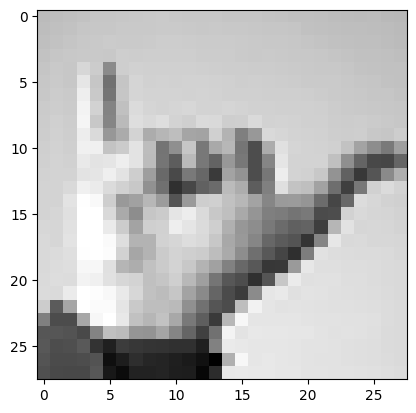

In [8]:
index = 4
plt.imshow(X_train[index].reshape(28, 28),cmap='gray')
plt.show()

The histogram of oriented gradients (HOG) is a feature descriptor used in computer vision and image processing for the purpose of object detection. The technique counts occurrences of gradient orientation in localized portions of an image.

In [9]:
from skimage.feature import hog

# Define the HOG parameters
orientations = 9
pixels_per_cell = (2, 2)
cells_per_block = (1, 1)

# Function to extract HOG features from a single image
def extract_features(img):
    #print(f"Image shape before HOG: {img.shape}")
    features = hog(img, orientations=orientations,
                   pixels_per_cell=pixels_per_cell,
                   cells_per_block=cells_per_block,
                   visualize=False,
                   transform_sqrt=True,
                   feature_vector=True,
                   block_norm='L2-Hys')
    #print(f"Feature shape: {features.shape}")
    return features

In [10]:
# Apply the extract_features function to all images in X_train and X_test
X_train_features = np.array([extract_features(img) for img in X_train])
X_test_features = np.array([extract_features(img) for img in X_test])

print(f"X_train_features Shape: {X_train_features.shape}")
print(f"X_test_features Shape: {X_test_features.shape}")


X_train_features Shape: (109820, 1764)
X_test_features Shape: (28688, 1764)


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=30)
hog_train_pca = pca.fit_transform(X_train_features)
hog_test_pca=pca.transform(X_test_features)
print(hog_test_pca.shape)
print(hog_train_pca.shape)

(28688, 30)
(109820, 30)


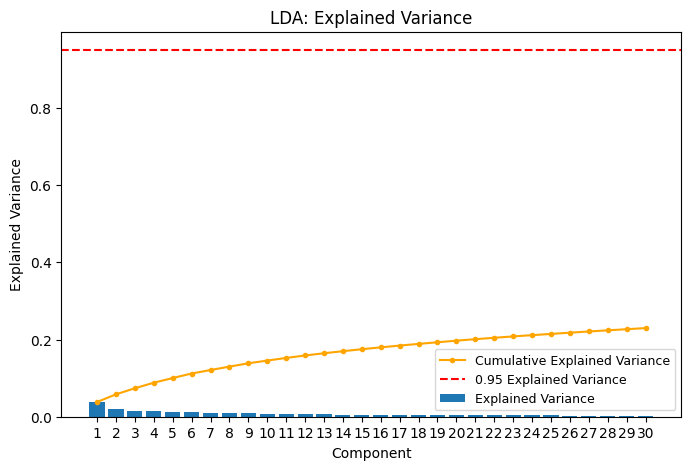

In [ ]:
#getting explained variance ratio from the lda model 
evr = pca.explained_variance_ratio_
components = range(1, len(evr) + 1)

#plotting scree plot
fig, ax = plt.subplots(figsize = (8,5))
ax.bar(x = components, height = evr, label = 'Explained Variance');
plt.plot(components, np.cumsum(evr), marker = '.', color = 'orange', label = 'Cumulative Explained Variance')
plt.axhline(y = .95, color = 'r', linestyle = '--', label = '0.95 Explained Variance')
plt.xticks(range(1, len(evr)+1));
plt.title('LDA: Explained Variance');
plt.xlabel('Component');
plt.ylabel('Explained Variance');
plt.legend(fontsize = 9);

In [ ]:
lr = LogisticRegression(C=3.4647045830997407,
                        max_iter=3171, 
                        penalty="l2", 
                        solver="liblinear",
                        warm_start=False)

In [ ]:
lr.fit(hog_train_pca, y_train)

LogisticRegression(C=3.4647045830997407, max_iter=3171, solver='liblinear')

In [ ]:
# applying Logistic regression and predicting on train
y_pred_lr_train = lr.predict(hog_train_pca)
# testing logistic regression on test data
y_pred_lr_test = lr.predict(hog_test_pca)

In [ ]:
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_lr_test)}")
print(f" Train Accuracy: {accuracy_score(y_train, y_pred_lr_train)}")

Test Accuracy: 0.5193112102621306
 Train Accuracy: 0.60978874521945


In [ ]:
#defining rfc with best parameters
rfc =RandomForestClassifier(n_estimators=8, 
                            min_samples_split=10,
                            min_samples_leaf=5, 
                            max_features=5,
                            max_depth=8, 
                            random_state=42)

In [ ]:
rfc.fit(hog_train_pca, y_train)

RandomForestClassifier(max_depth=8, max_features=5, min_samples_leaf=5,
                       min_samples_split=10, n_estimators=8, random_state=42)

In [ ]:
# applying Logistic regression and predicting on train
y_pred_rfc_train = rfc.predict(hog_train_pca)
# testing logistic regression on test data
y_pred_rfc_test = rfc.predict(hog_test_pca)

In [ ]:
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_rfc_test)}")
print(f" Train Accuracy: {accuracy_score(y_train, y_pred_rfc_train)}")

Test Accuracy: 0.4528025655326269
 Train Accuracy: 0.5998360954288836


In [ ]:
#standardized data 
#using sklearn standard scaler model and fitting on training data 
#sc = StandardScaler().fit(X_train.reshape(X_train.shape[0],-1))
X_train = X_train.reshape(X_train.shape[0],-1)
X_test = X_test.reshape(X_test.shape[0],-1)

In [ ]:
#define sklearn LDA object 
lda = LinearDiscriminantAnalysis()
#fit on training data 
lda.fit(X_train,y_train)

LinearDiscriminantAnalysis()

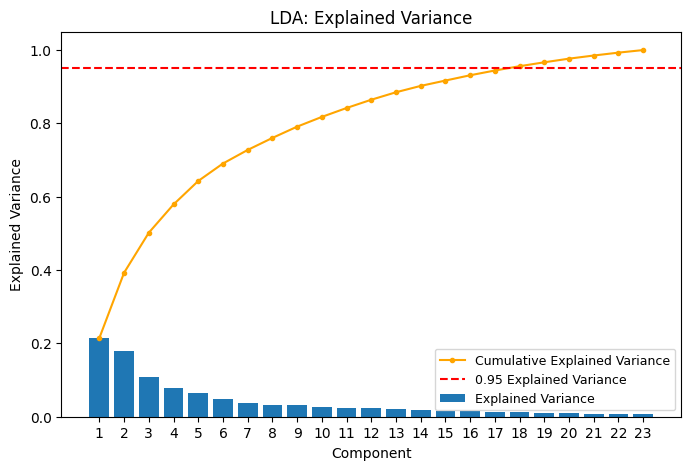

In [ ]:
#getting explained variance ratio from the lda model 
evr = lda.explained_variance_ratio_
components = range(1, len(evr) + 1)

#plotting scree plot
fig, ax = plt.subplots(figsize = (8,5))
ax.bar(x = components, height = evr, label = 'Explained Variance');
plt.plot(components, np.cumsum(evr), marker = '.', color = 'orange', label = 'Cumulative Explained Variance')
plt.axhline(y = .95, color = 'r', linestyle = '--', label = '0.95 Explained Variance')
plt.xticks(range(1, len(evr)+1));
plt.title('LDA: Explained Variance');
plt.xlabel('Component');
plt.ylabel('Explained Variance');
plt.legend(fontsize = 9);

In [ ]:
#fit on training data and transform
X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)

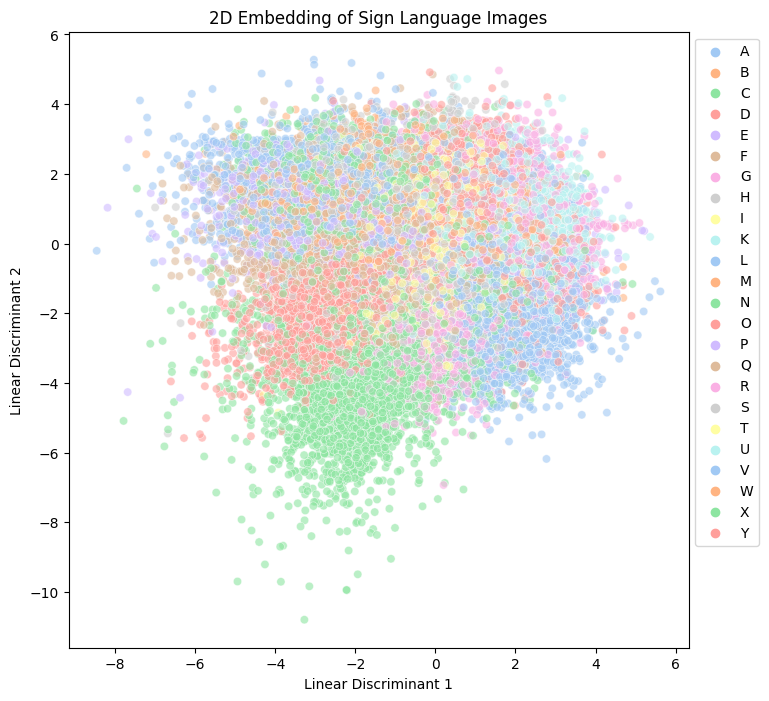

In [ ]:
fig, ax = plt.subplots(figsize = (8,8))
ax = sns.scatterplot(x = X_train_lda[:,0], y = X_train_lda[:,1], hue = y_train, palette = 'pastel',alpha=.6);
handler, _ = ax.get_legend_handles_labels();
plt.legend(handler, letters, bbox_to_anchor = (1, 1));
plt.title('2D Embedding of Sign Language Images')
plt.xlabel('Linear Discriminant 1');
plt.ylabel('Linear Discriminant 2');

In [ ]:
#define svm with best parameters
svm = SVC(kernel = 'rbf', gamma = 'auto', C = 2.6389473684210527)
#fit on training data 
svm.fit(X_train_lda,y_train)
#predict on training data 
y_pred_train = svm.predict(X_train_lda)
#predict on testing data
y_pred_test = svm.predict(X_test_lda)

In [ ]:
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_test)}")
print(f" Train Accuracy: {accuracy_score(y_train, y_pred_train)}")

Test Accuracy: 0.6904280535415505
 Train Accuracy: 0.8933345474412675


### Combining features

In [ ]:
# concatenate PCA and LDA features
X_train_combined = np.concatenate((hog_train_pca, X_train_lda), axis=1)
X_test_combined = np.concatenate((hog_test_pca, X_test_lda), axis=1)


In [ ]:
print(f"X_train Shape: {X_train_combined.shape}")
print(f"X_test Shape: {X_test_combined.shape}")

X_train Shape: (109820, 53)
X_test Shape: (28688, 53)


In [ ]:
lr.fit(X_train_combined, y_train)

LogisticRegression(C=3.4647045830997407, max_iter=3171, solver='liblinear')

In [ ]:
# applying Logistic regression and predicting on train
y_pred_lr_train = lr.predict(X_train_combined)
# testing logistic regression on test data
y_pred_lr_test = lr.predict(X_test_combined)

In [ ]:
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_lr_test)}")
print(f" Train Accuracy: {accuracy_score(y_train, y_pred_lr_train)}")

Test Accuracy: 0.6203639152258784
 Train Accuracy: 0.7423602258240758


In [ ]:
X_train=X_train_combined
X_test=X_test_combined

# Save the augmented data to files
np.savez_compressed('/content/drive/Shareddrives/SignLanguageData/combined_features_pca_lda.npz',
                    X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)


In [ ]:
# Load the augmented data from the file
data = np.load('/content/drive/Shareddrives/SignLanguageData/combined_features_pca_lda.npz')

In [ ]:
#printing shapes 
print(f'X_train Shape: {X_train.shape}')
print(f'y_train Shape: {y_train.shape}')
print(f'X_test Shape: {X_test.shape}')
print(f'y_test Shape: {y_test.shape}')

X_train Shape: (109820, 53)
y_train Shape: (109820,)
X_test Shape: (28688, 53)
y_test Shape: (28688,)


In [ ]:
from skimage.feature import hog

# Define the HOG parameters
orientations = 9
pixels_per_cell = (14, 14)
cells_per_block = (2, 2)

# Function to extract HOG features from a single image
def extract_features(img):
    #print(f"Image shape before HOG: {img.shape}")
    features = hog(img, orientations=orientations,
                   pixels_per_cell=pixels_per_cell,
                   cells_per_block=cells_per_block,
                   visualize=False,
                   transform_sqrt=True,
                   feature_vector=True,
                   block_norm='L2-Hys')
    #print(f"Feature shape: {features.shape}")
    return features

In [ ]:
# Apply the extract_features function to all images in X_train and X_test
X_train_features = np.array([extract_features(img) for img in X_train])
X_test_features = np.array([extract_features(img) for img in X_test])

print(f"X_train_features Shape: {X_train_features.shape}")
print(f"X_test_features Shape: {X_test_features.shape}")


X_train_features Shape: (109820, 36)
X_test_features Shape: (28688, 36)


Finding Best Number of Components with PCA

array([ 6., 50.])

In [12]:
from sklearn.decomposition import PCA

In [ ]:
train_acc = []
test_acc = []

for num_components in range(6,60,3):
  print(num_components)
  pca = PCA(n_components=num_components)
  hog_train_pca = pca.fit_transform(X_train_features)
  hog_test_pca = pca.transform(X_test_features)
  lr = LogisticRegression(C=3.4647045830997407,
                        max_iter=3171, 
                        penalty="l2", 
                        solver="liblinear",
                        warm_start=False)
  lr.fit(hog_train_pca,y_train)
  y_pred_lr_train = lr.predict(hog_train_pca)
  y_pred_lr_test = lr.predict(hog_test_pca)
  train_acc.append(accuracy_score(y_train,y_pred_lr_train))
  test_acc.append(accuracy_score(y_test,y_pred_lr_test))



In [31]:
print(train_acc)
print(test_acc)

[0.2889546530686578, 0.3486614460025496, 0.40948825350573664, 0.4615370606446913, 0.5029775997086141, 0.5424057548716081, 0.5698688763431069, 0.5877071571662721, 0.6106355855035512, 0.62650701147332, 0.6350209433618649, 0.6489801493352759, 0.6562374795119286, 0.6660899653979239, 0.6736022582407576, 0.6784010198506647, 0.6847022400291386, 0.6897104352576944, 0.6997177199052996, 0.7068657803678747, 0.7108085958841741, 0.7155618284465489, 0.7197322892005099, 0.724531050810417, 0.7272627936623566, 0.7296211983245311]
[0.2684049079754601, 0.3212144450641383, 0.36691299498047963, 0.4061628555493586, 0.44506413831567204, 0.4688022866703848, 0.49369074177356387, 0.5079475738984941, 0.5230409927495817, 0.5328360290016732, 0.5470231455660903, 0.5590142219743447, 0.5687744004461796, 0.5830312325711099, 0.5882250418293363, 0.5919896820970441, 0.5999721137757947, 0.6042247629670943, 0.6101854433909648, 0.6186907417735639, 0.622734244283324, 0.6253485778025656, 0.6246514221974344, 0.6278583379810374

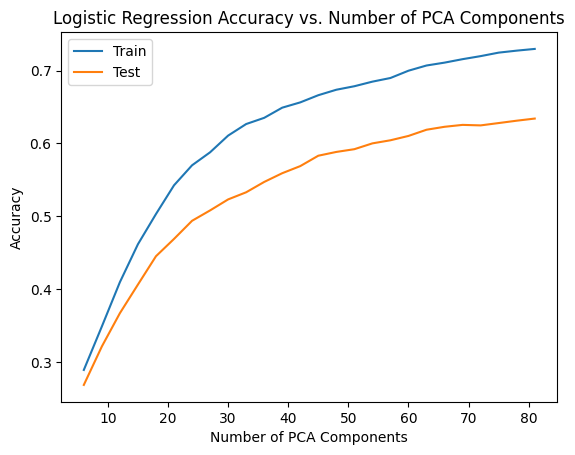

In [30]:
plt.plot(range(6,84,3),train_acc,label='Train')
plt.plot(range(6,84,3),test_acc,label='Test')
plt.title('Logistic Regression Accuracy vs. Number of PCA Components')
plt.xlabel('Number of PCA Components')
plt.ylabel('Accuracy')
plt.legend()


In [14]:
data = (X_train_features, X_test_features)
with open('/content/drive/Shareddrives/SignLanguageData/hog_features.pkl','wb') as f:
  pickle.dump(data,f)